# Project Summary: Victoria Rental Property Analysis

## Introduction

This project aims to analyze the rental property market in Victoria, Australia, to address the following key questions:

1. **What are the most important internal and external features in predicting rental prices?**
2. **What are the top 10 suburbs with the highest predicted growth rate?**
3. **According to chosen metrics, which suburbs are the most livable and affordable?**

To achieve this, we collected and processed various datasets, performed exploratory data analysis, engineered relevant features, built predictive models, and evaluated their performance.

---

## Overall Approach

### Data Collection

- **Rental Property Data**: Scraped rental listings from real estate websites, capturing property details such as price, number of bedrooms, bathrooms, parking spaces, and geographic coordinates.
- **Population Data**: Obtained population projections for Victoria's SA2 regions from the Australian Bureau of Statistics (ABS).
- **Income Data**: Sourced median and mean income data for SA2 regions from 2016-17 to 2020-21.
- **Geospatial Data**:
    - **Schools**: Acquired locations of schools in Victoria.
    - **Train Stations**: Gathered train station locations and annual patronage data.
    - **SA2 Shapefiles**: Downloaded SA2 boundary shapefiles for spatial analysis.

### Data Preprocessing

- **Data Cleaning**:
    - Handled missing values and inconsistencies in the datasets.
    - Corrected data types, especially for numeric fields with currency symbols or commas.
- **Geospatial Processing**:
    - Unified all spatial data to the same Coordinate Reference System (CRS), specifically EPSG:3857, for accurate spatial computations.
    - Mapped rental properties to their corresponding SA2 regions using spatial joins.

### Feature Engineering

- **Distance Calculations**:
    - Computed the distance from each property to the nearest train station using spatial indexing (`cKDTree`).
- **Proximity Counts**:
    - Calculated the number of schools within a 2 km radius of each property by leveraging spatial indexes and buffer zones.
- **Population Growth Rates**:
    - Calculated projected population growth rates for each SA2 region between 2022 and 2025 by pivoting and analyzing the population data.
- **Affordability Metrics**:
    - Determined the rent-to-income ratio for each SA2 region by combining rental prices and income data.
- **Livability Scores**:
    - Created a livability score based on normalized factors such as proximity to train stations and the number of nearby schools.

### Modeling

- **Data Preparation**:
    - Selected relevant features for modeling, including both property attributes and engineered features.
    - Encoded categorical variables (e.g., region) using label encoding.
    - Split the dataset into training and testing sets.
- **Model Selection and Training**:
    - Trained multiple regression models to predict rental prices:
        - Linear Regression
        - Random Forest Regressor
        - Gradient Boosting Regressor
        - XGBoost Regressor
        - Support Vector Regressor
- **Evaluation**:
    - Evaluated models using Root Mean Squared Error (RMSE) and R² score.
    - Compared model performances to select the best model.

### Evaluation

- **Model Performance Comparison**:
    
    
    | Model | RMSE | R² Score |
    | --- | --- | --- |
    | Linear Regression | 281.25 | 0.2635 |
    | Random Forest Regressor | 204.36 | 0.6112 |
    | Gradient Boosting Regressor | 220.06 | 0.5491 |
    | **XGBoost Regressor** | **192.59** | **0.6547** |
    | Support Vector Regressor | 327.02 | 0.0044 |
- **Feature Importance**:
    - Identified key features influencing rental prices using the XGBoost model's feature importance scores.
    - The most important features included the number of bedrooms, bathrooms, distance to the nearest train station, and the number of schools within 2 km.

---

## Issues Encountered

1. **Spatial Join Errors**:
    - Encountered `ValueError` due to conflicting column names (`index_left` and `index_right`) during spatial joins.
    - **Solution**: Renamed or dropped the conflicting columns before performing the join.
2. **Data Inconsistencies**:
    - The `region` column in the property data contained concatenated strings or incorrect values.
    - **Solution**: Cleaned and standardized the `region` data to ensure accurate mapping and grouping.
3. **Calculating Schools Within Radius**:
    - Initial method for counting schools within 2 km was not effective.
    - **Solution**: Implemented an alternative approach using spatial indexing and custom functions to accurately count nearby schools.
4. **Missing `liveability_score` Column**:
    - The `liveability_score` was missing, leading to errors in analysis.
    - **Solution**: Recalculated the `liveability_score` using available variables, such as normalized distances to train stations and the number of nearby schools.
5. **Model Selection Dilemma**:
    - While XGBoost had the best performance metrics, considerations about interpretability and computational efficiency arose.
    - **Solution**: Discussed the trade-offs and justified the model selection based on performance and project requirements.

---

## Limitations and Assumptions

- **Data Limitations**:
    - **Sample Size**: The rental property dataset may not represent the entire market due to limited scraping.
    - **Data Quality**: Potential inaccuracies in scraped data or public datasets could affect results.
    - **Temporal Mismatch**: Datasets from different years may not align perfectly, impacting the analysis.
- **Assumptions**:
    - **Uniform Growth Rate**: Assumed consistent annual growth rates for projecting future rental prices.
    - **Feature Independence**: Models assume that features are independent, which may not hold true in reality.
    - **Representativeness**: Assumed that the collected data is representative of the broader market trends.
- **Modeling Considerations**:
    - **Overfitting**: Complex models like XGBoost risk overfitting; cross-validation was used to mitigate this.
    - **Feature Selection**: Chose features based on availability and assumed relevance; other impactful features may exist.
- **Privacy and Compliance**:
    - Ensured compliance with data privacy regulations when using APIs and handling datasets.
    - Anonymized any personal or sensitive information in the datasets.

---

## Conclusion

The project provided insights into the rental property market in Victoria by:

- Identifying key factors that influence rental prices.
- Highlighting suburbs with the highest projected population growth.
- Determining the most livable and affordable suburbs based on combined livability and affordability scores.

Despite the challenges and limitations, the analysis offers valuable information for renters, investors, and policymakers.


# Import package

Imports the necessary libraries and packages for web scraping, data processing, geospatial analysis, and visualization. Each library serves a specific purpose in this rental price prediction project.

In [1]:
!pip install playwright beautifulsoup4 geopy geopandas shapely tqdm seaborn

In [2]:
!pip install --upgrade pip
!pip install tqdm

import warnings
warnings.filterwarnings('ignore')

import os
import time
import random
import urllib

import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from playwright.async_api import async_playwright
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point

# Part 1: Fetch data

Get house data using Playwright for automated browsing and BeautifulSoup for HTML parsing. Finaly extract the relevant property information and storing it in a list.

In [3]:
# Launches the Chromium browser in non-headless mode, allowing visual observation of the scraping process.

is_crawl = False
if is_crawl:
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless = False)

In [6]:
import asyncio
import time
import random
import pandas as pd
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright

# 维多利亚省所有主要区域的列表
victoria_regions = [
    "melbourne-vic", 
    "geelong-vic",
   "ballarat-vic", 
    "bendigo-vic" ,
   "warrnambool-vic", "mildura-vic",
    "shepparton-vic", "latrobe-valley-vic"
    "wangaratta-vic", "wodonga-vic",
    "horsham-vic", "bairnsdale-vic" ,
    "echuca-vic", "ararat-vic",
   "colac-vic", "hamilton-vic"
    # 可根据需要继续补充更多区域
]

async def crawl_data_victoria_rent(region_name):
    clean_data = []
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        for page_index in range(1, 50):
            try:
                page = await browser.new_page()
                content = await page.goto(f"https://www.domain.com.au/rent/?keywords={region_name}&page={page_index}", wait_until="commit", timeout=5000)
                content = await content.text()
                content = BeautifulSoup(content, 'html.parser')

                if content.find('ul', {"data-testid": "results"}) is None:
                    await page.close()
                    break

                house_datas = content.find_all('ul', {"data-testid": "results"})[0].find_all('li')
            except Exception as e:
                print(f"Error on page {page_index} for region {region_name}: {e}")
                time.sleep(random.randint(1, 3))
                await page.close()
                continue

            if len(house_datas) == 0:
                break

            for house_data in house_datas:
                try:
                    # 处理两种房源数据: listing-card-carousel 和 listing-card-wrapper-standardpp
                    branding_div = house_data.find("div", {"data-testid": "listing-card-branding"})
                    if not branding_div:
                        branding_div = house_data.find("div", {"data-testid": "listing-card-wrapper-standardpp"})
                    
                    # 获取 agent 信息
                    if branding_div:
                        agent_info = branding_div.get_text(separator="\n").split('\n')
                        agent_name = agent_info[0] if len(agent_info) > 0 else "N/A"
                        agent_company = agent_info[1] if len(agent_info) > 1 else "N/A"
                    else:
                        agent_name = "N/A"
                        agent_company = "N/A"
                    
                    # 获取价格和地址
                    price = house_data.find("p", {"data-testid": "listing-card-price"})
                    price = price.text.strip() if price else "N/A"

                    address1 = house_data.find("span", {"data-testid": "address-line1"})
                    address1 = address1.text.strip() if address1 else "N/A"

                    address2 = house_data.find("span", {"data-testid": "address-line2"})
                    address2 = address2.text.strip() if address2 else "N/A"

                    # 获取房源的特征信息（卧室、浴室、停车位等）
                    features = [x.text for x in house_data.find_all("span", {"data-testid": "property-features-feature"})]

                    # Assigning feature values, handling cases where not all features are available
                    bed = features[0] if len(features) > 0 else 'N/A'
                    bath = features[1] if len(features) > 1 else 'N/A'
                    parking = features[2] if len(features) > 2 else 'N/A'
                    floor_space = features[3] if len(features) > 3 else 'N/A'

                    clean_data.append([
                        agent_name.strip(), agent_company.strip(), price.strip(),
                        address1.strip(), address2.strip(), bed.strip(), bath.strip(), parking.strip(), floor_space.strip()
                    ])
                except Exception as e:
                    print(f"Error processing house data in {region_name}: {e}")
                    continue

            await page.close()
            time.sleep(random.randint(1, 3))

            print(f"Region: {region_name}, Page {page_index}, Total Listings: {len(clean_data)}")

        await browser.close()

    # Save the data to a CSV file for the specific region
    df = pd.DataFrame(clean_data, columns=["Agent Name", "Agent Company", "Price", "Address Line 1", "Address Line 2", "Bedrooms", "Bathrooms", "Parking", "Floor Space"])
    df.to_csv(f'{region_name}_rent_listings.csv', index=False)
    print(f"Data saved to {region_name}_rent_listings.csv")


async def main():
    # 为每个区域运行爬虫任务
    tasks = [crawl_data_victoria_rent(region) for region in victoria_regions]
    await asyncio.gather(*tasks)

# 运行主函数（适用于 Jupyter Notebook）
await main()


Error: BrowserType.launch: Executable doesn't exist at /Users/zhangqiyue/Library/Caches/ms-playwright/chromium-1134/chrome-mac/Chromium.app/Contents/MacOS/Chromium
╔════════════════════════════════════════════════════════════╗
║ Looks like Playwright was just installed or updated.       ║
║ Please run the following command to download new browsers: ║
║                                                            ║
║     playwright install                                     ║
║                                                            ║
║ <3 Playwright Team                                         ║
╚════════════════════════════════════════════════════════════╝

In [1]:
import pandas as pd
import os

# 维多利亚省所有主要区域的列表
victoria_regions = [
       "melbourne-vic", 
    "geelong-vic",
   "ballarat-vic", 
    "bendigo-vic" ,
   "warrnambool-vic", "mildura-vic",
    "shepparton-vic", "latrobe-valley-vic"
    "wangaratta-vic", "wodonga-vic",
    "horsham-vic", "bairnsdale-vic" ,
    "echuca-vic", "ararat-vic",
   "colac-vic", "hamilton-vic"
]

# 存储合并后的数据
combined_data = pd.DataFrame()

# 循环遍历每个区域对应的 CSV 文件
for region in victoria_regions:
    file_name = f'{region}_rent_listings.csv'
    
    if os.path.exists(file_name):
        # 读取该区域的 CSV 文件
        df = pd.read_csv(file_name)
        
        # 添加一列标识该数据的区域
        df['Region'] = region
        
        # 将该区域的数据追加到总的 DataFrame 中
        combined_data = pd.concat([combined_data, df], ignore_index=True)
    else:
        print(f"File not found: {file_name}")

# 保存合并后的数据到一个新的 CSV 文件
combined_data.to_csv('victoria_combined_rent_listings.csv', index=False)
print("All data combined and saved to victoria_combined_rent_listings.csv")


All data combined and saved to victoria_combined_rent_listings.csv


# Part 2: Prepocess data

- convert addresses into geographic coordinates

In [2]:
!pip install opencage


import pandas as pd
import os
from tqdm import tqdm
from opencage.geocoder import OpenCageGeocode

def geocode_addresses(file_path, updated_file_path, num_records=10):
    # Step 1: Load existing data from CSV or create new data
    if os.path.exists(updated_file_path):
        # If the updated file with lat/long already exists, load it
        properties_df = pd.read_csv(updated_file_path)
        print(f"Loaded existing data from {updated_file_path}")
    else:
        # Load the original data
        properties_df = pd.read_csv(file_path)

        # Limit the data to num_records (default is 10000)
        properties_df = properties_df.head(num_records)

        # Drop rows with missing address fields
        properties_df.dropna(subset=['Address Line 1', 'Address Line 2'], inplace=True)

        # Create empty lists to store latitude and longitude
        latitudes = []
        longitudes = []

        # Initialize OpenCage Geocode API
        api_key = 'bfd72baf24d54842bced29afa4ec2311'  # Replace with your actual OpenCage API key
        geocoder = OpenCageGeocode(api_key)

        # Total number of addresses
        total_addresses = len(properties_df)

        # Initialize progress bar with total addresses
        with tqdm(total=total_addresses, desc="Geocoding addresses") as pbar:
            for row in properties_df.itertuples(index=False, name=None):
                # Concatenate address using the actual column names 'Address Line 1' and 'Address Line 2'
                full_address = f"{row[0]}, {row[1]}"

                try:
                    # Geocode the address using OpenCage
                    results = geocoder.geocode(full_address)

                    if results and len(results):
                        latitudes.append(results[0]['geometry']['lat'])
                        longitudes.append(results[0]['geometry']['lng'])
                    else:
                        latitudes.append(None)
                        longitudes.append(None)
                except Exception as e:
                    latitudes.append(None)
                    longitudes.append(None)
                    print(f"Error geocoding address '{full_address}': {e}")

                # Update progress bar
                pbar.update(1)

        # Add latitude and longitude to the dataframe
        properties_df['latitude'] = latitudes
        properties_df['longitude'] = longitudes

        # Save the updated data to a new CSV file
        properties_df.to_csv(updated_file_path, index=False)
        print(f"Geocoding completed. The data has been saved as '{updated_file_path}'.")

    # Step 2: Load the updated data and proceed with further analysis or usage
    properties_df = pd.read_csv(updated_file_path)
    print("Data loaded from updated CSV with latitude and longitude.")

# Call the function to process 10000 records
file_path = "victoria_combined_rent_listings.csv"
updated_file_path = "victoria_combined_rent_listings_with_latlong.csv"
geocode_addresses(file_path, updated_file_path)

ModuleNotFoundError: No module named 'opencage'

- cleaning and standardizing the scraped data

In [7]:
import pandas as pd
import os


def merge_geocoded_files(output_folder, merged_file_path):
    # List all CSV files in the output folder
    csv_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.csv')]

    # Read and concatenate all CSV files
    merged_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

    # Save the merged dataframe to a new CSV file
    merged_df.to_csv(merged_file_path, index=False)
    print(f"All geocoded files have been merged and saved as '{merged_file_path}'.")


if __name__ == '__main__':
    output_folder = "geocoded_output"

    # Merge all geocoded files
    merged_file_path = "geocoded_output/merged_geocoded_data.csv"
    merge_geocoded_files(output_folder, merged_file_path)

All geocoded files have been merged and saved as 'geocoded_output/merged_geocoded_data.csv'.


In [8]:
import pandas as pd

# 读取CSV文件
clean_df = pd.read_csv('merged_geocoded_data.csv')


clean_df.shape

(7691, 12)

In [9]:
clean_df['price'] = clean_df['price'].astype(str).str.extract(r'(\d+(?:,\d{3})*)')[0].str.replace(',', '').fillna(0).astype(float).astype(int)
clean_df['bed'] = clean_df['bed'].astype(str).str.extract(r'(\d+)').fillna(0).astype(int)
clean_df['bath'] = clean_df['bath'].astype(str).str.extract(r'(\d+)').fillna(0).astype(int)
clean_df['parking'] = clean_df['parking'].astype(str).str.extract(r'(\d+)').fillna(0).astype(int)


In [10]:
import numpy as np

clean_df['price'] = clean_df['price'].replace(0, np.nan)
clean_df['bed'] = clean_df['bed'].replace(0, np.nan)
clean_df['bath'] = clean_df['bath'].replace(0, np.nan)
clean_df['parking'] = clean_df['parking'].replace(0, np.nan)

# If 'floor_space' exists in your DataFrame, do the same for it
if 'floor_space' in clean_df.columns:
    clean_df['floor_space'] = clean_df['floor_space'].replace(0, np.nan)
# 将清理后的数据框存入CSV文件
clean_df.to_csv('vic_data.csv', index=False)

In [11]:
clean_df

,Agent Name,Agent Company,price,Address Line 1,Address Line 2,bed,bath,parking,floor_space,region,latitude,longitude
0,Kim Te,Motion Property,480.0,"104A/2A Duffy Street,",ESSENDON NORTH VIC 3041,1.0,1.0,1.0,NaN,latrobe-valley-vicwangaratta-vic,-37.713300,144.896900
1,Queanbeyan Property Management,Blackshaw Queanbeyan & Jerrabomberra,590.0,"226/7 Irving Street,",PHILLIP ACT 2606,1.0,1.0,1.0,NaN,latrobe-valley-vicwangaratta-vic,-35.339691,149.084286
2,Tim Miosge,Cream Residential,400.0,"11b/30 Launceston Street,",LYONS ACT 2606,1.0,1.0,1.0,NaN,latrobe-valley-vicwangaratta-vic,-35.339834,149.082031
3,NaN,NaN,1050.0,"30 Downes Place,",HUGHES ACT 2605,4.0,3.0,2.0,NaN,latrobe-valley-vicwangaratta-vic,-35.330531,149.102068
4,Tim Miosge,Cream Residential,680.0,"74 Launceston Street,",LYONS ACT 2606,3.0,1.0,1.0,NaN,latrobe-valley-vicwangaratta-vic,-35.339834,149.082031
...,...,...,...,...,...,...,...,...,...,...,...,...
7686,NaN,NaN,345.0,"117/386 Burwood Highway,",BURWOOD VIC 3125,1.0,1.0,NaN,NaN,bendigo-vic,-37.849800,145.119000
7687,NaN,NaN,590.0,"32 Golconda Avenue,",FRANKSTON VIC 3199,3.0,1.0,2.0,NaN,bendigo-vic,-38.141114,145.149335
7688,NaN,NaN,380.0,"313 King Street,",BENDIGO VIC 3550,2.0,1.0,2.0,NaN,bendigo-vic,-36.763180,144.279088
7689,NaN,NaN,380.0,"6/406 Lower Heidelberg Road,",EAGLEMONT VIC 3084,1.0,1.0,1.0,100m²,bendigo-vic,-37.765824,145.067058


# Part 3: Extrernal data

## Main Structure and Greater Capital City Statistical Areas

https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files#downloads-for-gda2020-digital-boundary-files


In [12]:
!pip install geopandas
import geopandas as gpd
sa2 = gpd.read_file('./SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
sa2.head()

Task exception was never retrieved
future: <Task finished name='Task-52' coro=<Connection.run.<locals>.init() done, defined at /Users/zhangqiyue/miniconda3/lib/python3.9/site-packages/playwright/_impl/_connection.py:269> exception=Exception('Connection.init: Connection closed while reading from the driver')>
Traceback (most recent call last):
  File "/Users/zhangqiyue/miniconda3/lib/python3.9/site-packages/playwright/_impl/_connection.py", line 270, in init
    self.playwright_future.set_result(await self._root_object.initialize())
  File "/Users/zhangqiyue/miniconda3/lib/python3.9/site-packages/playwright/_impl/_connection.py", line 212, in initialize
    await self._channel.send(
  File "/Users/zhangqiyue/miniconda3/lib/python3.9/site-packages/playwright/_impl/_connection.py", line 59, in send
    return await self._connection.wrap_api_call(
  File "/Users/zhangqiyue/miniconda3/lib/python3.9/site-packages/playwright/_impl/_connection.py", line 514, in wrap_api_call
    raise rewrite_

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."


<Axes: >

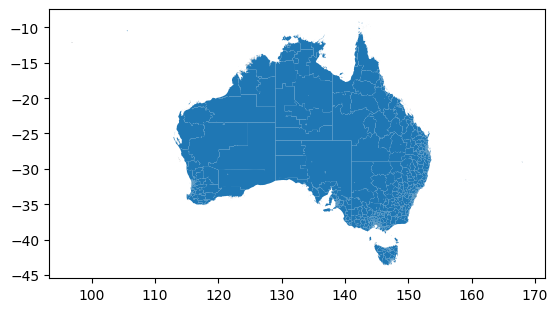

In [13]:
sa2.plot()

<Axes: >

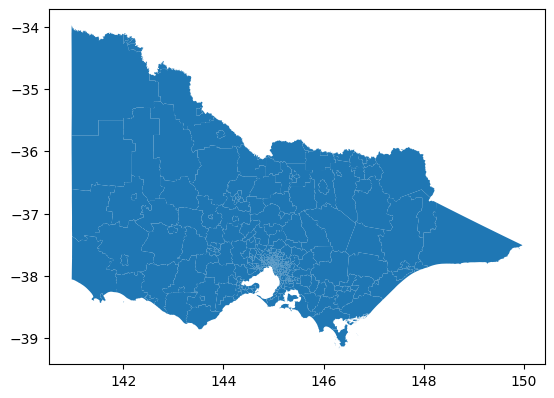

In [14]:
sa2[sa2['STE_NAME21'] == 'Victoria'].plot()

In [15]:
sa2[sa2['STE_NAME21'] == 'Victoria']['SA2_NAME21'].sample(20).values

array(['Ararat', 'Woodend', 'Ballarat East - Warrenheip',
       'Edithvale - Aspendale', 'St Albans - North', 'Templestowe Lower',
       'Doncaster East - South', 'Viewbank - Yallambie',
       'Mordialloc - Parkdale', 'Beaconsfield - Officer',
       'Warrnambool - North', 'Hoppers Crossing - South', 'Sydenham',
       'Essendon (West) - Aberfeldie', 'Newtown (Vic.)',
       'Lockington - Gunbower', 'Bentleigh - McKinnon', 'Collingwood',
       'Ivanhoe', 'Wandin - Seville'], dtype=object)

In [5]:
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)


<Figure size 640x480 with 0 Axes>

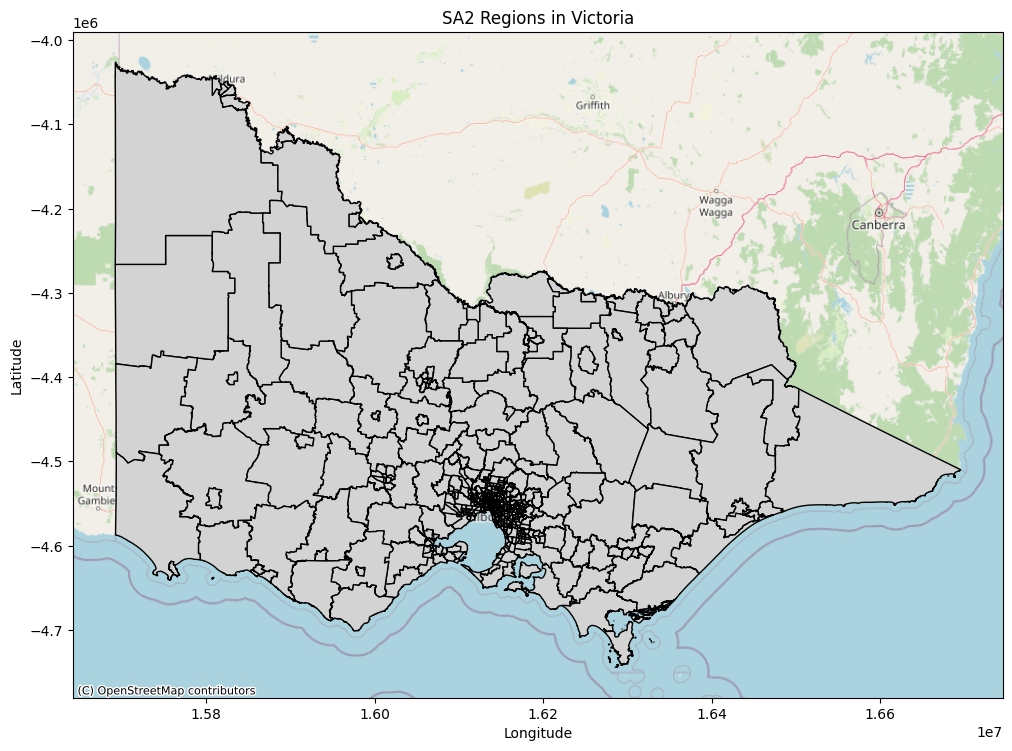

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Load SA2 shapefile
sa2 = gpd.read_file('./SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')

# Filter for Victoria
sa2_vic = sa2[sa2['STE_NAME21'] == 'Victoria']

# Set coordinate reference system to Web Mercator
sa2_vic = sa2_vic.to_crs(epsg=3857)

# Plot SA2 regions
fig, ax = plt.subplots(figsize=(12, 12))
sa2_vic.plot(ax=ax, color='lightgray', edgecolor='black')

# Option A: Try using 'Stamen Toner Lite'
#ctx.add_basemap(ax, source=ctx.providers['Stamen Toner Lite'])

# Option B: If Option A doesn't work, try 'Stamen_TonerLite'
# ctx.add_basemap(ax, source=ctx.providers.Stamen_TonerLite)

# Option C: Use OpenStreetMap as an alternative
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('SA2 Regions in Victoria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import matplotlib.colors as mcolors


In [13]:
# Load SA2 shapefile
sa2 = gpd.read_file('./SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')

# Filter for Victoria
sa2_vic = sa2[sa2['STE_NAME21'] == 'Victoria']

# Set coordinate reference system to Web Mercator for compatibility with basemaps
sa2_vic = sa2_vic.to_crs(epsg=3857)


In [15]:
# Load properties data
properties = pd.read_csv('vic_data.csv')

# Create geometry column
geometry = [Point(xy) for xy in zip(properties['longitude'], properties['latitude'])]
properties_gdf = gpd.GeoDataFrame(properties, geometry=geometry, crs='EPSG:4326')

# Reproject to match SA2 CRS
properties_gdf = properties_gdf.to_crs(epsg=3857)
# Spatial join properties with sa2_vic to find properties within Victoria
properties_vic = gpd.sjoin(properties_gdf, sa2_vic, how='inner', predicate='within')


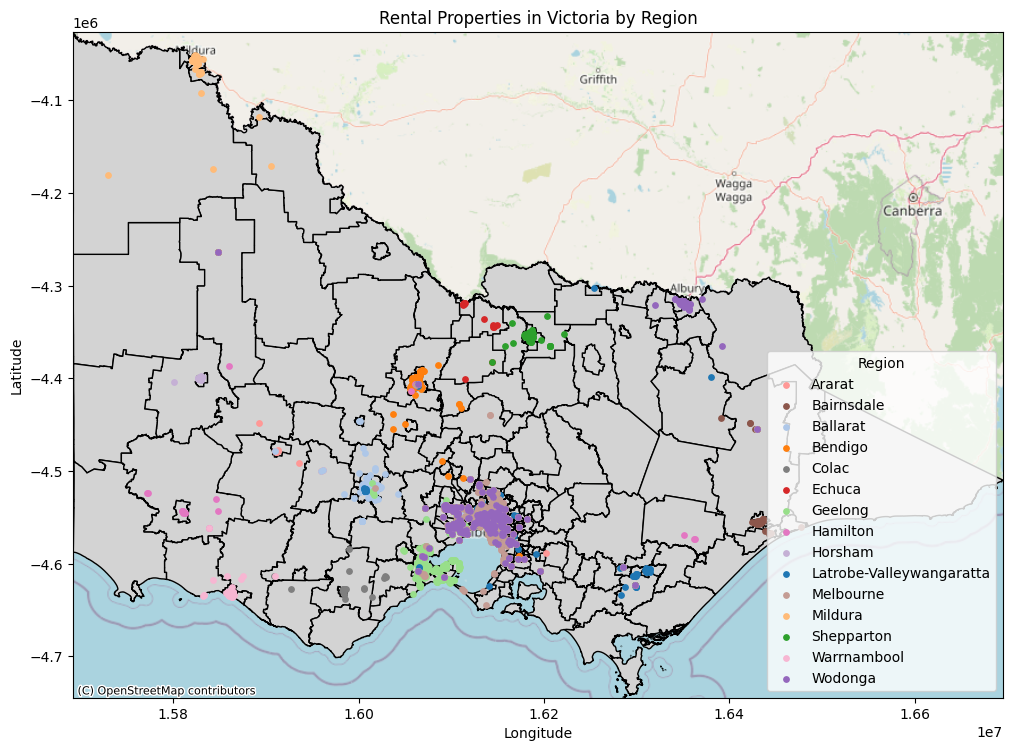

In [20]:
unique_regions = properties_vic['region'].unique()
# Choose a colormap with enough colors
colors = plt.cm.tab20.colors  # 20 distinct colors

# Map each region to a color
region_color_map = {region: colors[i % len(colors)] for i, region in enumerate(unique_regions)}
# Plot SA2 regions
fig, ax = plt.subplots(figsize=(12, 12))
sa2_vic.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot properties, coloring by region
for region, data in properties_vic.groupby('region'):
    data.plot(
        ax=ax,
        markersize=15,
        color=region_color_map[region],
        label=region.replace('-vic', '').title()
    )

# Add basemap tiles
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set the x and y limits to focus on Victoria
ax.set_xlim(sa2_vic.total_bounds[[0, 2]])
ax.set_ylim(sa2_vic.total_bounds[[1, 3]])

plt.title('Rental Properties in Victoria by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='lower right', title='Region', fontsize='medium')
plt.show()


In [22]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import matplotlib.colors as mcolors


In [23]:
# Load population data
population_data = pd.read_csv('ABS_PopProj_2232_SA2_7288895535057254268.csv')

# Display the first few rows
population_data.head()


/var/folders/bd/0ttx7nbs6h98pjzjryhsrz7h0000gn/T/ipykernel_59084/3135786881.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  population_data = pd.read_csv('ABS_PopProj_2232_SA2_7288895535057254268.csv')


,OBJECTID,Statistical Areas Level 2 2021 code,Statistical Areas Level 2 2021 name,Reference date,Projected males aged 0-4 years,Projected males aged 5-9 years,Projected males aged 10-14 years,Projected males aged 15-19 years,Projected males aged 20-24 years,Projected males aged 25-29 years,...,Projected females aged 70-74 years,Projected females aged 75-79 years,Projected females aged 80-84 years,Projected females aged 85+,Projected persons (total),Area in square kilometres,Uniform Resource Identifier,globalid,Shape__Area,Shape__Length
0,1,101021007,Braidwood,6/30/2022 12:00:00 AM,108,154,140,95,56,76,...,132,148,52,43,4366,3418.3525,https://linked.data.gov.au/dataset/asgsed3/SA2...,77b82dfa-1db6-4e1e-a534-fa7ccd4a8936,0.339397,3.913694
1,2,101021007,Braidwood,6/30/2023 12:00:00 AM,115,147,142,96,60,63,...,138,137,66,44,4443,3418.3525,https://linked.data.gov.au/dataset/asgsed3/SA2...,93c6e806-ec79-4ea0-82ac-ae96e212fb4c,0.339397,3.913694
2,3,101021007,Braidwood,6/30/2024 12:00:00 AM,111,151,135,109,56,58,...,131,138,72,50,4518,3418.3525,https://linked.data.gov.au/dataset/asgsed3/SA2...,2988c234-3125-4ca9-9e77-b7a503b19ab0,0.339397,3.913694
3,4,101021007,Braidwood,6/30/2025 12:00:00 AM,116,143,141,110,56,61,...,120,135,77,56,4589,3418.3525,https://linked.data.gov.au/dataset/asgsed3/SA2...,e2e7342c-a8e9-4cfd-8f87-457f26a96fec,0.339397,3.913694
4,5,101021007,Braidwood,6/30/2026 12:00:00 AM,117,140,148,107,59,61,...,119,130,84,58,4654,3418.3525,https://linked.data.gov.au/dataset/asgsed3/SA2...,07031bd9-9f01-449a-9850-d3a427d6cade,0.339397,3.913694


In [24]:
# Load train station patronage data
train_station_data = pd.read_csv('Annual_Regional_Train_Station_Entries_2023-24.csv')

# Create geometry column
geometry = [Point(xy) for xy in zip(train_station_data['Stop_long'], train_station_data['Stop_lat'])]
train_station_gdf = gpd.GeoDataFrame(train_station_data, geometry=geometry, crs='EPSG:4326')

# Reproject to match SA2 CRS
train_station_gdf = train_station_gdf.to_crs(epsg=3857)


In [25]:
# Load traffic counts data
traffic_counts = pd.read_csv('Traffic_Count_Locations.csv')

# Create geometry column
geometry = [Point(xy) for xy in zip(traffic_counts['X'], traffic_counts['Y'])]
traffic_counts_gdf = gpd.GeoDataFrame(traffic_counts, geometry=geometry, crs='EPSG:4326')

# Reproject to match SA2 CRS
traffic_counts_gdf = traffic_counts_gdf.to_crs(epsg=3857)


In [27]:
# Load school data
school_data = pd.read_csv('dv346-schoollocations2023.csv', encoding='latin')

# Create geometry column
geometry = [Point(xy) for xy in zip(school_data['X'], school_data['Y'])]
school_gdf = gpd.GeoDataFrame(school_data, geometry=geometry, crs='EPSG:4326')

# Reproject to match SA2 CRS
school_gdf = school_gdf.to_crs(epsg=3857)


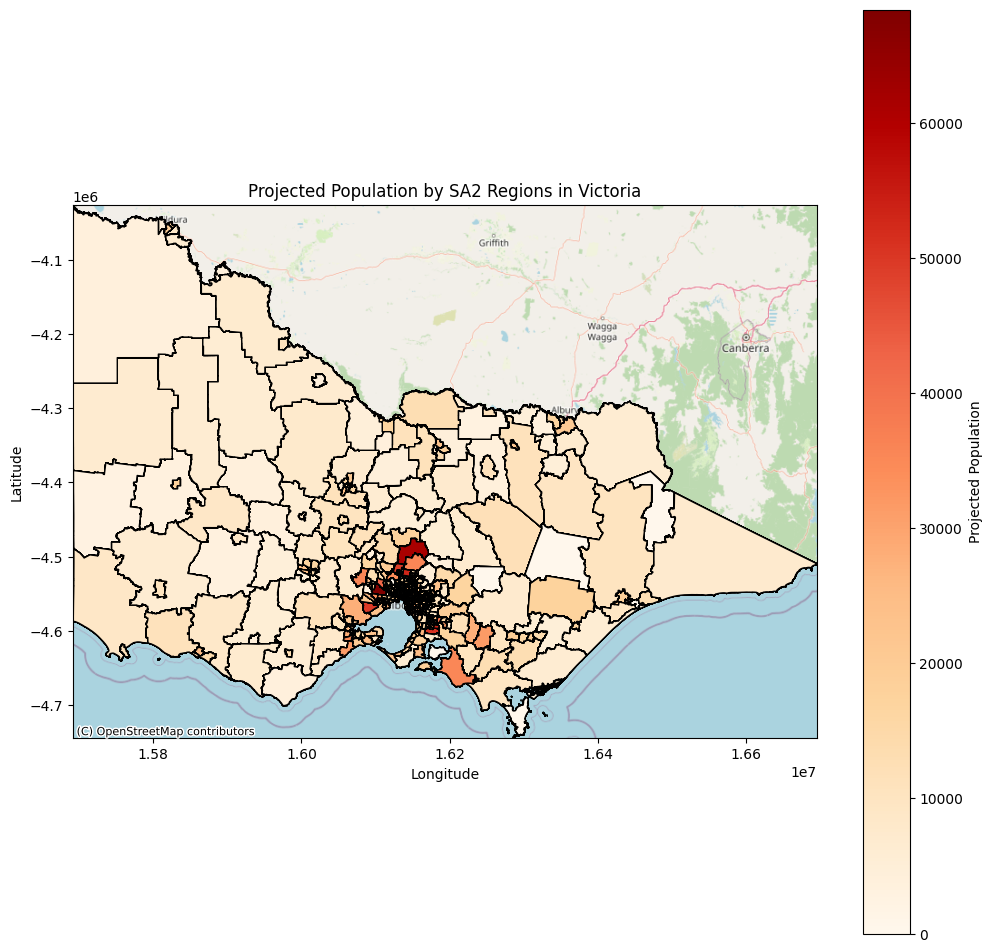

In [28]:
# Merge population data with SA2 GeoDataFrame
sa2_vic_pop = sa2_vic.merge(
    population_data[['Statistical Areas Level 2 2021 name', 'Projected persons (total)']],
    left_on='SA2_NAME21',
    right_on='Statistical Areas Level 2 2021 name',
    how='left'
)

# Plot choropleth map
fig, ax = plt.subplots(figsize=(12, 12))
sa2_vic_pop.plot(
    column='Projected persons (total)',
    ax=ax,
    legend=True,
    cmap='OrRd',
    edgecolor='black',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "No Data",
    },
    legend_kwds={'label': "Projected Population", 'orientation': "vertical"}
)

# Add basemap tiles
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set axes limits
ax.set_xlim(sa2_vic.total_bounds[[0, 2]])
ax.set_ylim(sa2_vic.total_bounds[[1, 3]])

plt.title('Projected Population by SA2 Regions in Victoria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


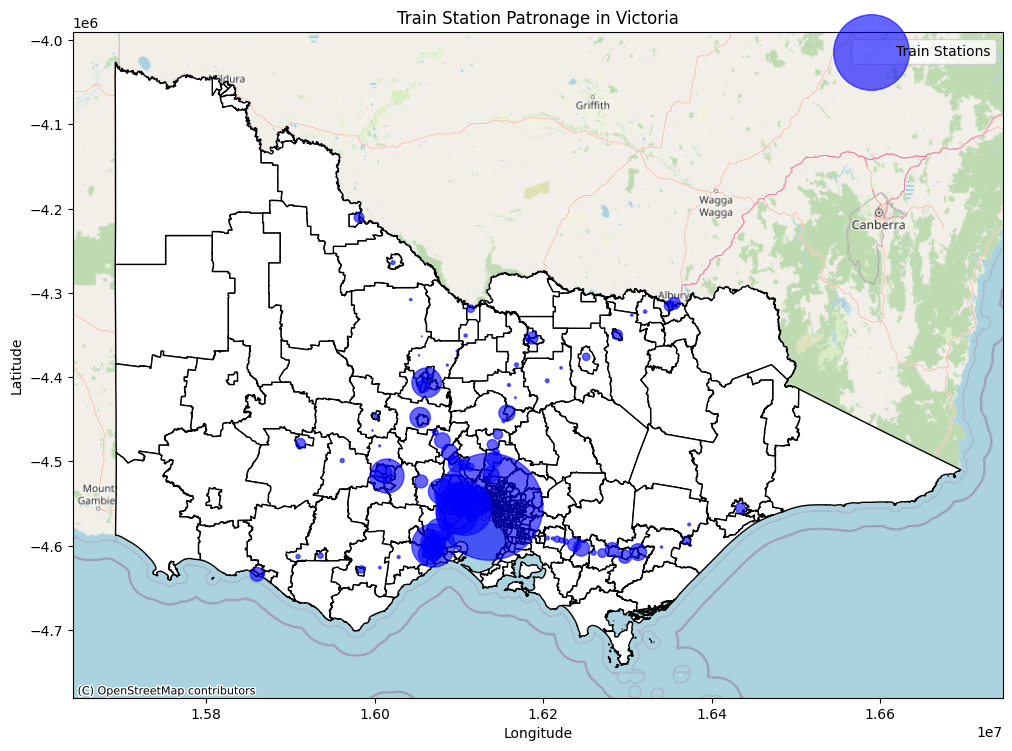

In [29]:
# Plot SA2 regions
fig, ax = plt.subplots(figsize=(12, 12))
sa2_vic.plot(ax=ax, color='white', edgecolor='black')

# Plot train stations with sizes based on annual patronage
train_station_gdf.plot(
    ax=ax,
    markersize=train_station_gdf['Pax_annual'] / 1000,  # Adjust divisor as needed for visibility
    color='blue',
    alpha=0.6,
    label='Train Stations'
)

# Add basemap tiles
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Train Station Patronage in Victoria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


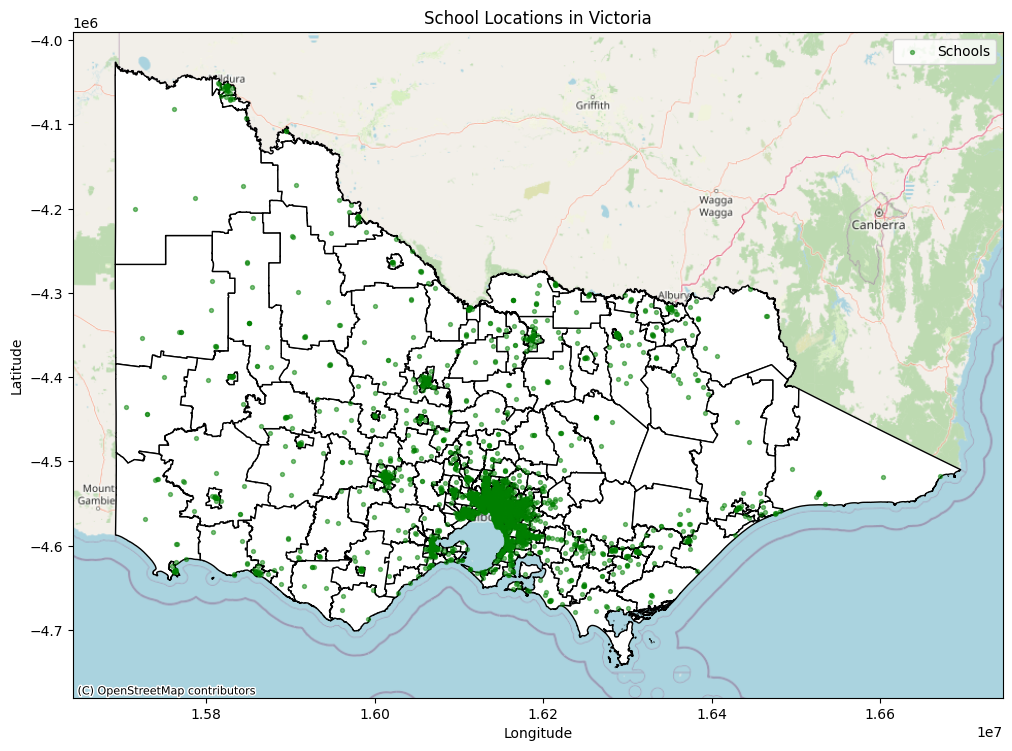

In [32]:
# Plot SA2 regions
fig, ax = plt.subplots(figsize=(12, 12))
sa2_vic.plot(ax=ax, color='white', edgecolor='black')

# Plot school locations
school_gdf.plot(
    ax=ax,
    markersize=8,
    color='green',
    alpha=0.5,
    label='Schools'
)

# Add basemap tiles
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('School Locations in Victoria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [33]:
# Ensure both GeoDataFrames use the same CRS
properties_vic = properties_vic.to_crs(epsg=3857)
train_station_gdf = train_station_gdf.to_crs(epsg=3857)

# Calculate the nearest train station for each property
from scipy.spatial import cKDTree

# Extract coordinates
property_coords = [(geom.x, geom.y) for geom in properties_vic.geometry]
station_coords = [(geom.x, geom.y) for geom in train_station_gdf.geometry]

# Build KDTree for efficient nearest-neighbor search
station_tree = cKDTree(station_coords)

# Query nearest train station for each property
distances, indices = station_tree.query(property_coords, k=1)

# Add distances to properties_vic GeoDataFrame
properties_vic['distance_to_station'] = distances  # Distance in meters

# Optionally, add station names
properties_vic['nearest_station'] = train_station_gdf.iloc[indices]['Stop_name'].values


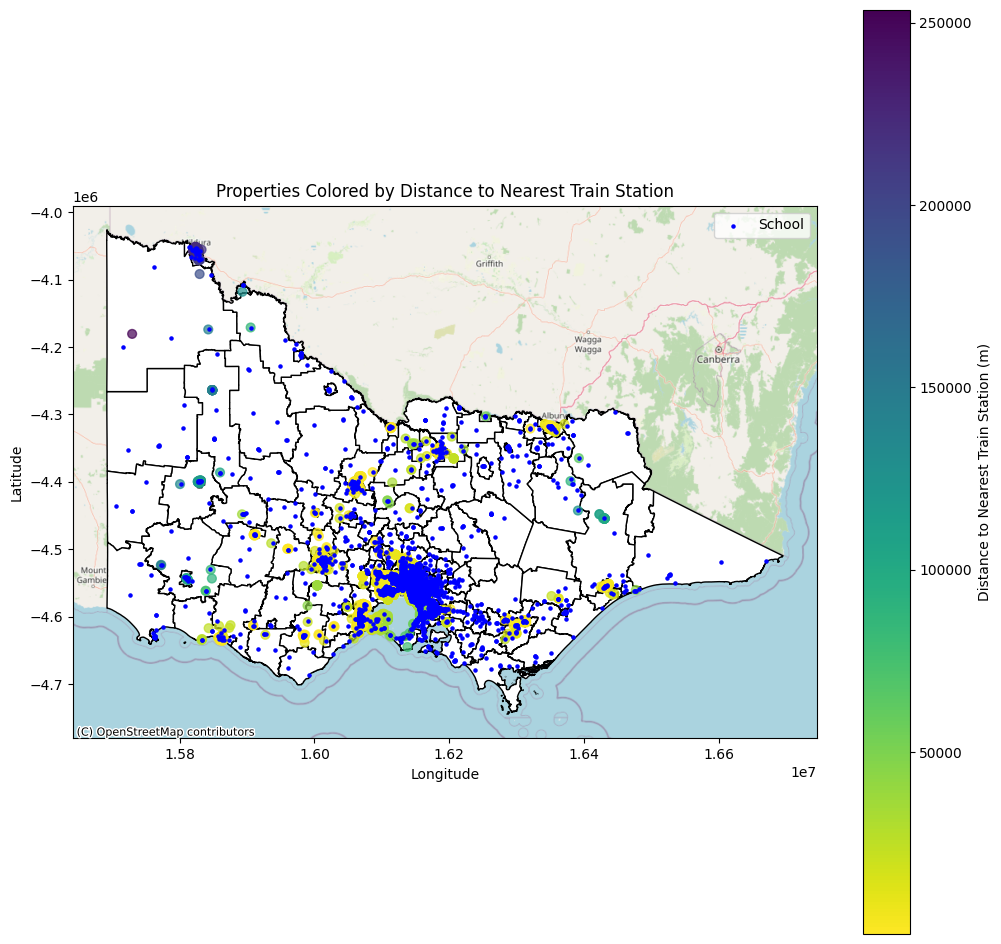

In [36]:
# Plot properties colored by distance to nearest train station
fig, ax = plt.subplots(figsize=(12, 12))
sa2_vic.plot(ax=ax, color='white', edgecolor='black')

# Normalize distances for color mapping
norm = plt.Normalize(vmin=properties_vic['distance_to_station'].min(), vmax=properties_vic['distance_to_station'].max())

# Plot properties
properties_vic.plot(
    ax=ax,
    column='distance_to_station',
    markersize=40,
    cmap='viridis_r',
    alpha=0.7,
    legend=True,
    legend_kwds={'label': "Distance to Nearest Train Station (m)", 'orientation': "vertical"}
)

# Add train stations
school_gdf.plot(
    ax=ax,
    markersize=5,
    color='blue',
    label='School'
)

# Add basemap tiles
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Properties Colored by Distance to Nearest Train Station')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [67]:
# Reproject to a metric CRS (e.g., EPSG:3857 for meters)
properties_vic = properties_vic.to_crs(epsg=3857)
school_gdf = school_gdf.to_crs(epsg=3857)
# Build spatial index
school_sindex = school_gdf.sindex

In [68]:
from shapely.geometry import Point

def count_schools_within_radius(property_geom, radius=2000):
    # Create a buffer around the property
    property_buffer = property_geom.buffer(radius)
    # Get possible matches from the spatial index
    possible_matches_index = list(school_sindex.intersection(property_buffer.bounds))
    possible_matches = school_gdf.iloc[possible_matches_index]
    # Filter schools that are actually within the buffer
    precise_matches = possible_matches[possible_matches.intersects(property_buffer)]
    return len(precise_matches)



In [69]:
# Apply the function to count schools within 2 km for each property
properties_vic['schools_within_2km'] = properties_vic['geometry'].apply(count_schools_within_radius)


In [42]:
# Load properties data
properties = pd.read_csv('vic_data.csv')

# Fix the 'region' column if it's concatenated
properties['region'] = properties['region'].apply(lambda x: x.split('vic')[0] + 'vic' if 'vic' in x else x)

# Alternatively, if there are multiple regions, choose one or handle accordingly


In [46]:
# Check for missing values
print(properties_vic.isnull().sum())

# Summary statistics
print(properties_vic.describe())


Agent Name             5318
Agent Company          5364
price                   207
Address Line 1            0
Address Line 2            0
bed                     194
bath                    132
parking                1262
floor_space            6044
region                    0
latitude                  0
longitude                 0
geometry                  0
index_right               0
SA2_CODE21                0
SA2_NAME21                0
CHG_FLAG21                0
CHG_LBL21                 0
SA3_CODE21                0
SA3_NAME21                0
SA4_CODE21                0
SA4_NAME21                0
GCC_CODE21                0
GCC_NAME21                0
STE_CODE21                0
STE_NAME21                0
AUS_CODE21                0
AUS_NAME21                0
AREASQKM21                0
LOCI_URI21                0
distance_to_station       0
nearest_station           0
dtype: int64
              price          bed         bath      parking     latitude  \
count   6349.000

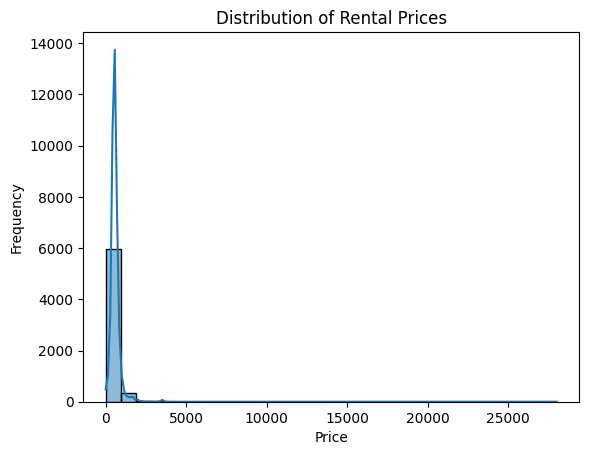

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(properties_vic['price'], bins=30, kde=True)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


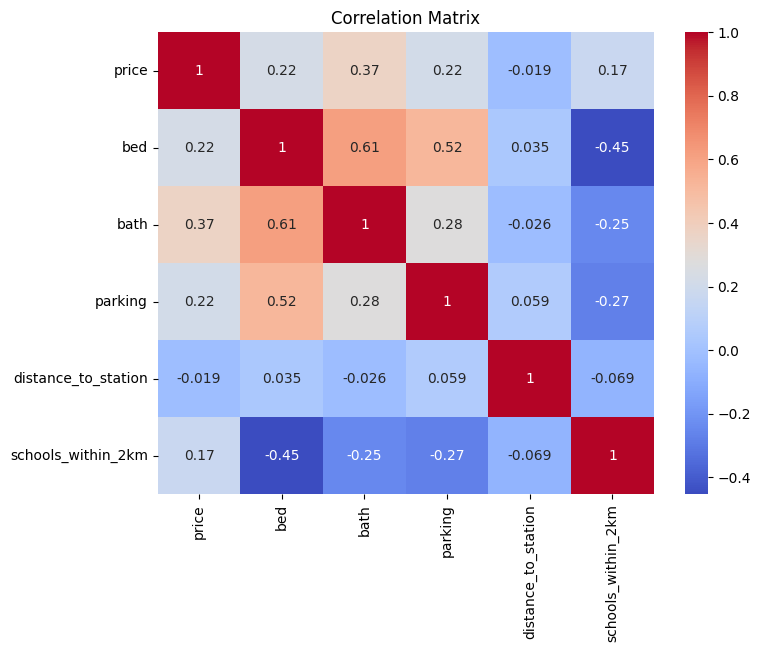

In [70]:
# Prepare data
features = ['price', 'bed', 'bath', 'parking', 'distance_to_station','schools_within_2km']
data_numeric = properties_vic[features].dropna()

# Compute correlation matrix
corr_matrix = data_numeric.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [71]:
# Remove rows with NaN values in the 'price' column
properties_vic = properties_vic.dropna(subset=['price'])

# Verify the removal
nan_count = properties_vic['price'].isna().sum()
print(f"Number of NaN values in 'price' after removal: {nan_count}")

Number of NaN values in 'price' after removal: 0


In [74]:
# Select features and target variable
features = ['bed', 'bath', 'parking', 'distance_to_station', 'schools_within_2km']
X = properties_vic[features].fillna(0)
y = properties_vic['price']

# If 'region' is a significant feature, encode it
from sklearn.preprocessing import LabelEncoder

# Encode 'region' if it's in your data
if 'region' in properties_vic.columns:
    le = LabelEncoder()
    X['region_encoded'] = le.fit_transform(properties_vic['region'].fillna('Unknown'))


In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print('Linear Regression:')
print(f'RMSE: {rmse_lr}')
print(f'R^2 Score: {r2_lr}')


Linear Regression:
RMSE: 281.24987456350823
R^2 Score: 0.2635397000252614


/Users/zhangqiyue/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [77]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print('\nRandom Forest Regressor:')
print(f'RMSE: {rmse_rf}')
print(f'R^2 Score: {r2_rf}')



Random Forest Regressor:
RMSE: 204.355489060323
R^2 Score: 0.6111901303296038


/Users/zhangqiyue/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [78]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb = r2_score(y_test, y_pred_gb)

print('\nGradient Boosting Regressor:')
print(f'RMSE: {rmse_gb}')
print(f'R^2 Score: {r2_gb}')



Gradient Boosting Regressor:
RMSE: 220.05850564516632
R^2 Score: 0.5491407496692333


/Users/zhangqiyue/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [79]:
# Install XGBoost if not already installed
# !pip install xgboost

from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print('\nXGBoost Regressor:')
print(f'RMSE: {rmse_xgb}')
print(f'R^2 Score: {r2_xgb}')



XGBoost Regressor:
RMSE: 192.58901776211047
R^2 Score: 0.6546752532151963


/Users/zhangqiyue/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [80]:
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)
rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
r2_svr = r2_score(y_test, y_pred_svr)

print('\nSupport Vector Regressor:')
print(f'RMSE: {rmse_svr}')
print(f'R^2 Score: {r2_svr}')



Support Vector Regressor:
RMSE: 327.01618847715406
R^2 Score: 0.004358087627180152


/Users/zhangqiyue/.local/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Model Performance Comparison:
                      Model        RMSE  R^2 Score
0         Linear Regression  281.249875   0.263540
1             Random Forest  204.355489   0.611190
2         Gradient Boosting  220.058506   0.549141
3                   XGBoost  192.589018   0.654675
4  Support Vector Regressor  327.016188   0.004358


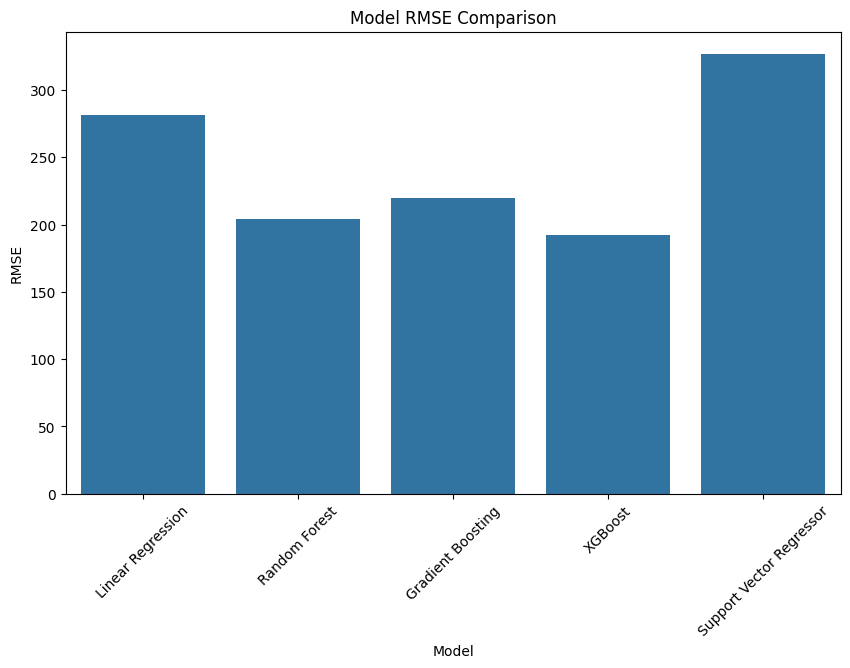

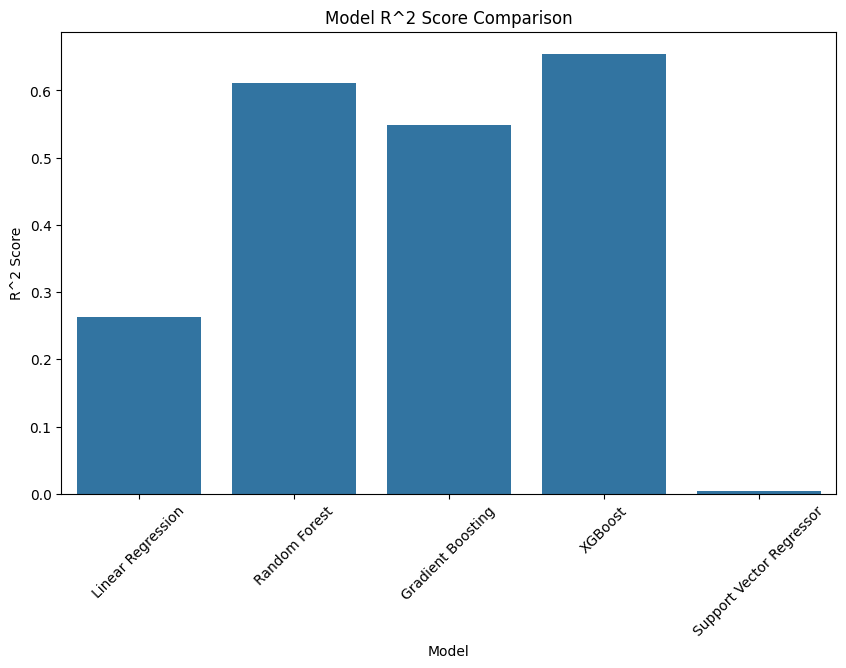

In [81]:
# Create a DataFrame to compare results
model_performance = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'Support Vector Regressor'],
    'RMSE': [rmse_lr, rmse_rf, rmse_gb, rmse_xgb, rmse_svr],
    'R^2 Score': [r2_lr, r2_rf, r2_gb, r2_xgb, r2_svr]
})

print('\nModel Performance Comparison:')
print(model_performance)
import seaborn as sns
import matplotlib.pyplot as plt

# RMSE Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=model_performance)
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

# R^2 Score Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R^2 Score', data=model_performance)
plt.title('Model R^2 Score Comparison')
plt.ylabel('R^2 Score')
plt.xticks(rotation=45)
plt.show()


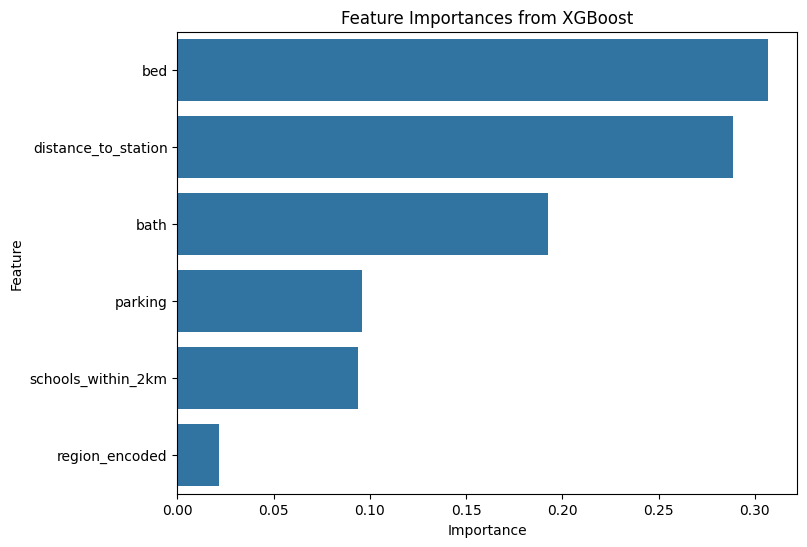

In [110]:
# XGBoost is the best model
importances = xgb_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from XGBoost')
plt.show()


In [85]:
# Load population data
population_data = pd.read_csv('ABS_PopProj_2232_SA2_7288895535057254268.csv')

# Ensure 'Reference date' is in datetime format
population_data['Reference date'] = pd.to_datetime(population_data['Reference date'])


# Assuming SA2 regions in sa2_vic
vic_sa2_names = sa2_vic['SA2_NAME21'].unique()
population_vic = population_data[population_data['Statistical Areas Level 2 2021 name'].isin(vic_sa2_names)]


/var/folders/bd/0ttx7nbs6h98pjzjryhsrz7h0000gn/T/ipykernel_59084/1491077355.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  population_data = pd.read_csv('ABS_PopProj_2232_SA2_7288895535057254268.csv')
/var/folders/bd/0ttx7nbs6h98pjzjryhsrz7h0000gn/T/ipykernel_59084/1491077355.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  population_data['Reference date'] = pd.to_datetime(population_data['Reference date'])


In [87]:
import numpy as np

# Pivot the data to have years as columns
pop_pivot = population_vic.pivot_table(
    index='Statistical Areas Level 2 2021 name',
    columns='Reference date',
    values='Projected persons (total)'
).reset_index()

# Rename columns for clarity
pop_pivot.columns = ['SA2_NAME21'] + [f'population_{date.year}' for date in pop_pivot.columns[1:]]

# Calculate growth rate between 2022 and 2025
pop_pivot['growth_rate'] = (
    (pop_pivot['population_2025'] - pop_pivot['population_2022']) / pop_pivot['population_2022']
)

# Handle any division by zero or missing data
pop_pivot['growth_rate'] = pop_pivot['growth_rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [88]:
# Merge with properties data based on SA2 region
properties_vic = properties_vic.merge(
    pop_pivot[['SA2_NAME21', 'growth_rate']],
    left_on='SA2_NAME21', right_on='SA2_NAME21', how='left'
)

# If properties data doesn't have 'SA2_NAME21', perform a spatial join to add SA2 names
# Group by SA2 region and calculate average growth rate
region_growth_rates = properties_vic.groupby('SA2_NAME21')['growth_rate'].mean().reset_index()

# Sort regions by growth rate
top10_growth_regions = region_growth_rates.sort_values(by='growth_rate', ascending=False).head(10)

print('Top 10 Suburbs with Highest Predicted Growth Rate:')
print(top10_growth_regions)


Top 10 Suburbs with Highest Predicted Growth Rate:
                          SA2_NAME21  growth_rate
235        Port Melbourne Industrial     2.910233
289                  Tarneit - North     0.658350
121           Fraser Rise - Plumpton     0.638499
246        Rockbank - Mount Cottrell     0.552504
77               Clyde North - South     0.537957
287  Tarneit (West) - Mount Cottrell     0.452676
317             Wyndham Vale - North     0.391580
78         Cobblebank - Strathtulloh     0.380738
269   Southbank (West) - South Wharf     0.315087
181            Melbourne CBD - North     0.290078


In [94]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import contextily as ctx
# Load income data
income_data = pd.read_csv('incomedata.csv')

# Display the first few rows
income_data.head()


,SA2,SA2 NAME,2016-17Median ($),2017-18Median ($),2018-19Median ($),2019-20Median ($),2020-21Median ($),2016-17Mean ($),2017-18Mean ($),2018-19Mean ($),2019-20Mean ($),2020-21Mean ($)
0,Australia,NaN,"48,083","49,805","51,389","52,338","54,890","63,508","64,247","65,954","67,255","70,522"
1,Victoria,NaN,"47,457","49,266","51,027","51,996","54,008","62,354","63,432","65,368","66,660","69,694"
2,201011001,Alfredton,"50,596","52,448","53,932","55,204","58,036","60,937","62,343","63,731","65,781","69,111"
3,201011002,Ballarat,"50,093","51,736","53,688","53,784","55,998","72,750","74,917","77,952","78,498","83,800"
4,201011005,Buninyong,"48,877","51,034","52,377","54,308","56,408","61,067","61,593","63,338","64,381","67,558"


In [99]:
import numpy as np

# Remove any rows with missing SA2 NAME
income_data = income_data.dropna(subset=['SA2 NAME'])

# Convert income columns to numeric by removing commas and converting to float
income_columns = [col for col in income_data.columns if 'Median' in col or 'Mean' in col]


# Calculate average median income for each SA2 region
income_data['average_median_income'] = income_data[
    ['2016-17Median ($)', '2017-18Median ($)', '2018-19Median ($)', '2019-20Median ($)', '2020-21Median ($)']
].mean(axis=1)

# Ensure 'SA2_NAME21' is in properties_vic
if 'SA2_NAME21' not in properties_vic.columns:
    # Perform spatial join to assign SA2 names to properties
    properties_vic = gpd.sjoin(properties_vic, sa2_vic[['SA2_NAME21', 'geometry']], how='left', predicate='within')


In [100]:
# Calculate average rental price per SA2 region
average_rent_per_sa2 = properties_vic.groupby('SA2_NAME21')['price'].mean().reset_index()
average_rent_per_sa2.rename(columns={'price': 'average_rent'}, inplace=True)
# Merge income data with average rent
affordability_data = pd.merge(
    income_data[['SA2 NAME', 'average_median_income']],
    average_rent_per_sa2,
    left_on='SA2 NAME',
    right_on='SA2_NAME21',
    how='inner'
)
# Calculate annual rent (assuming rent is weekly)
affordability_data['annual_rent'] = affordability_data['average_rent'] * 52

# Calculate rent-to-income ratio
affordability_data['rent_to_income_ratio'] = affordability_data['annual_rent'] / affordability_data['average_median_income']


In [102]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize distance to train station (smaller distance is better)
properties_vic['norm_distance_to_station'] = 1 - scaler.fit_transform(properties_vic[['distance_to_station']])

# Normalize number of schools within 2 km (more schools is better)
properties_vic['norm_schools_within_2km'] = scaler.fit_transform(properties_vic[['schools_within_2km']])

# If you have other variables, normalize them similarly
# For example, if you have proximity to parks or shopping centers


In [103]:
# Assign weights to each factor (adjust weights as appropriate)
weight_distance = 0.5
weight_schools = 0.5

# Calculate the liveability score
properties_vic['liveability_score'] = (
    properties_vic['norm_distance_to_station'] * weight_distance +
    properties_vic['norm_schools_within_2km'] * weight_schools
)


In [104]:
# Calculate average liveability score per SA2 region
average_liveability_per_sa2 = properties_vic.groupby('SA2_NAME21')['liveability_score'].mean().reset_index()


In [105]:
# Merge liveability data with affordability data
combined_data = pd.merge(
    affordability_data,
    average_liveability_per_sa2,
    left_on='SA2 NAME',
    right_on='SA2_NAME21',
    how='inner'
)
# Normalize rent_to_income_ratio (lower is better, so invert the scale)
combined_data['norm_affordability'] = 1 - scaler.fit_transform(combined_data[['rent_to_income_ratio']])

# Normalize liveability_score (higher is better)
combined_data['norm_liveability'] = scaler.fit_transform(combined_data[['liveability_score']])

# Calculate combined score
combined_data['combined_score'] = (
    combined_data['norm_affordability'] * 0.5 +  # Adjust weights as needed
    combined_data['norm_liveability'] * 0.5
)


Top 10 Most Liveable and Affordable Suburbs:
              SA2 NAME  combined_score
122   Hawthorn - North        0.980765
88           Parkville        0.978334
113            Fitzroy        0.974875
123   Hawthorn - South        0.972239
112        Collingwood        0.963408
84             Carlton        0.958809
80          Flemington        0.957933
167     Preston - East        0.952474
114      Fitzroy North        0.952173
107  Prahran - Windsor        0.941291


/var/folders/bd/0ttx7nbs6h98pjzjryhsrz7h0000gn/T/ipykernel_59084/1338328813.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


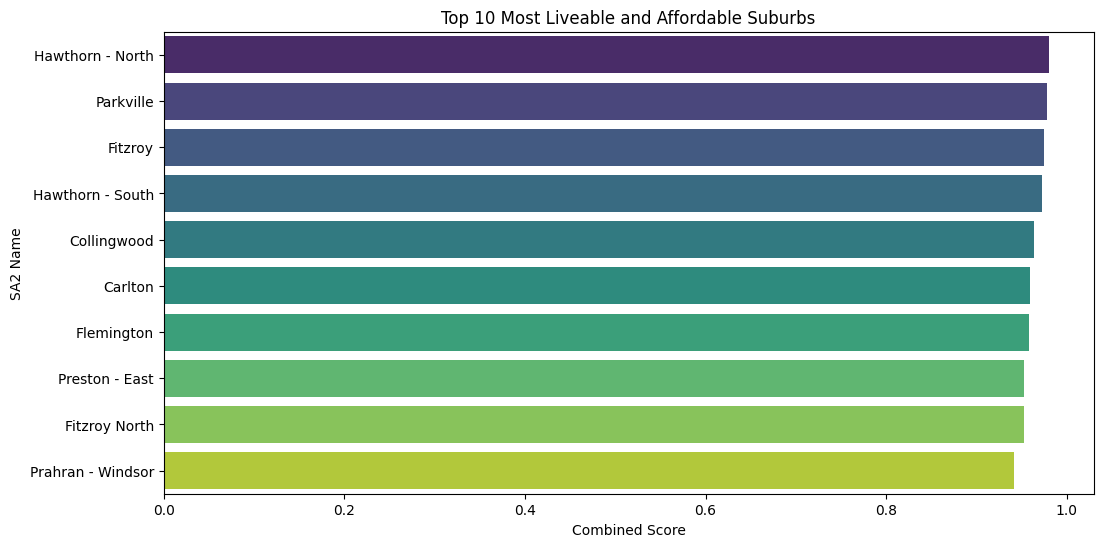

In [106]:
# Sort suburbs by combined score
top_suburbs = combined_data.sort_values(by='combined_score', ascending=False).head(10)

print('Top 10 Most Liveable and Affordable Suburbs:')
print(top_suburbs[['SA2 NAME', 'combined_score']])
# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    x='combined_score',
    y='SA2 NAME',
    data=top_suburbs,
    palette='viridis'
)
plt.title('Top 10 Most Liveable and Affordable Suburbs')
plt.xlabel('Combined Score')
plt.ylabel('SA2 Name')
plt.show()


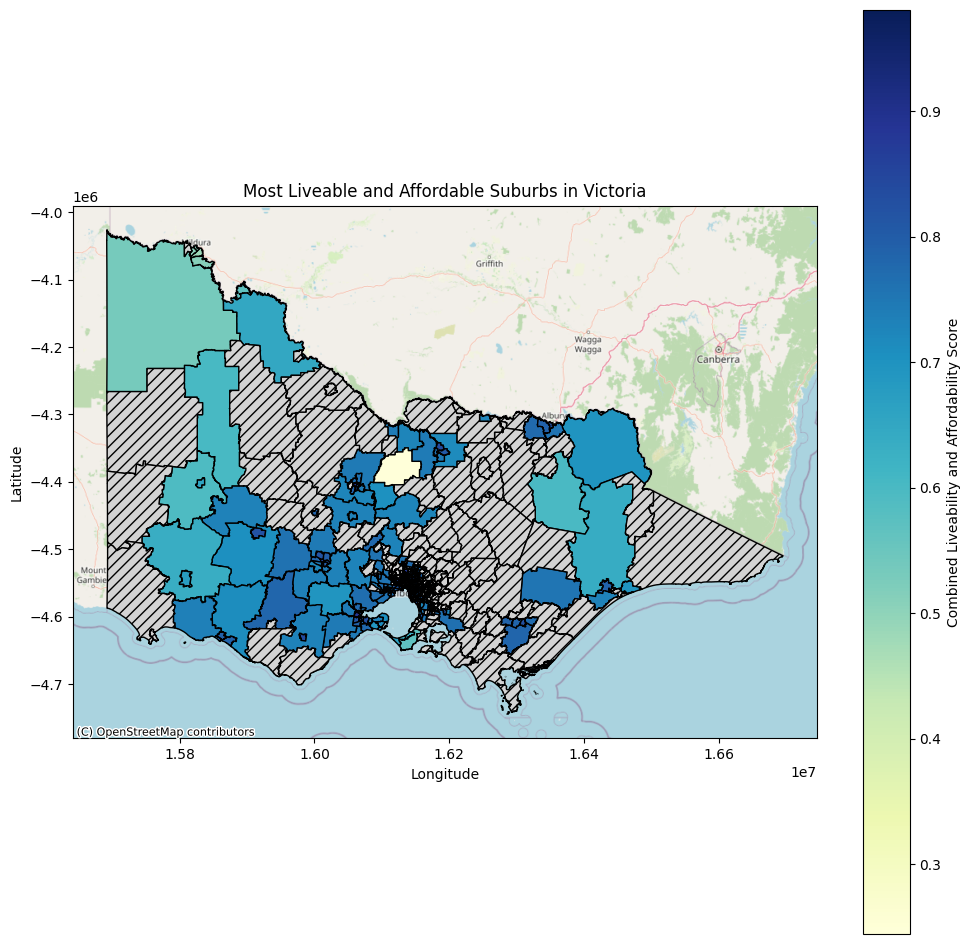

In [107]:
# Merge combined scores with SA2 GeoDataFrame
sa2_vic_scores = sa2_vic.merge(
    combined_data[['SA2 NAME', 'combined_score']],
    left_on='SA2_NAME21',
    right_on='SA2 NAME',
    how='left'
)

# Plot the map
fig, ax = plt.subplots(figsize=(12, 12))
sa2_vic_scores.plot(
    column='combined_score',
    ax=ax,
    legend=True,
    cmap='YlGnBu',
    edgecolor='black',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "No Data",
    },
    legend_kwds={'label': "Combined Liveability and Affordability Score", 'orientation': "vertical"}
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Most Liveable and Affordable Suburbs in Victoria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
